In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.arima.model import ARIMA

# Set seed for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and sort data
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data = data.sort_values(by='Time')

# Define features
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Scale data
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)

# Define dataset sizes
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Convert to tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define upgraded model with more layers and heads
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=6, decoder_layers=6, d_model=128, nhead=16, dropout=0.3):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Initialize model
model = MultiDeT()

# Define loss function and optimizer with weight decay
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# Train model with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            output1 = output1.view(-1)
            output2 = output2.view(-1)

            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                output1 = output1.view(-1)
                output2 = output2.view(-1)

                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)
            break

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            output1 = output1.view(-1)
            output2 = output2.view(-1)

            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Evaluate the model
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Plot predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()

# Calculate residuals
residuals_pm = true_values_pm - predicted_values_pm
residuals_pm_steam = true_values_pm_steam - predicted_values_pm_steam

# Fit ARIMA model to residuals
arima_order = (5, 1, 0)  # Example order, you may need to tune this
arima_model_pm = ARIMA(residuals_pm, order=arima_order).fit()
arima_model_pm_steam = ARIMA(residuals_pm_steam, order=arima_order).fit()

# Forecast residuals using ARIMA
arima_forecast_pm = arima_model_pm.forecast(steps=len(residuals_pm))
arima_forecast_pm_steam = arima_model_pm_steam.forecast(steps=len(residuals_pm_steam))

# Combine predictions
final_predictions_pm = predicted_values_pm + arima_forecast_pm
final_predictions_pm_steam = predicted_values_pm_steam + arima_forecast_pm_steam

# Plot final predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(final_predictions_pm, label='Final Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot final predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(final_predictions_pm_steam, label='Final Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()

/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Training Loss: 0.8957
Epoch 1/100, Validation Loss: 0.9390
Epoch 2/100, Training Loss: 0.7895
Epoch 2/100, Validation Loss: 0.9553
Epoch 3/100, Training Loss: 0.7415
Epoch 3/100, Validation Loss: 0.9931
Epoch 4/100, Training Loss: 0.7037
Epoch 4/100, Validation Loss: 1.0257
Epoch 5/100, Training Loss: 0.6737
Epoch 5/100, Validation Loss: 1.0018
Epoch 6/100, Training Loss: 0.6472
Epoch 6/100, Validation Loss: 1.0947
Epoch 7/100, Training Loss: 0.6270
Epoch 7/100, Validation Loss: 1.1670
Epoch 8/100, Training Loss: 0.5931
Epoch 8/100, Validation Loss: 1.3186
Epoch 9/100, Training Loss: 0.5839
Epoch 9/100, Validation Loss: 1.2758
Epoch 10/100, Training Loss: 0.5702
Epoch 10/100, Validation Loss: 1.2241
Epoch 11/100, Training Loss: 0.5646
Epoch 11/100, Validation Loss: 1.2206
Early stopping triggered


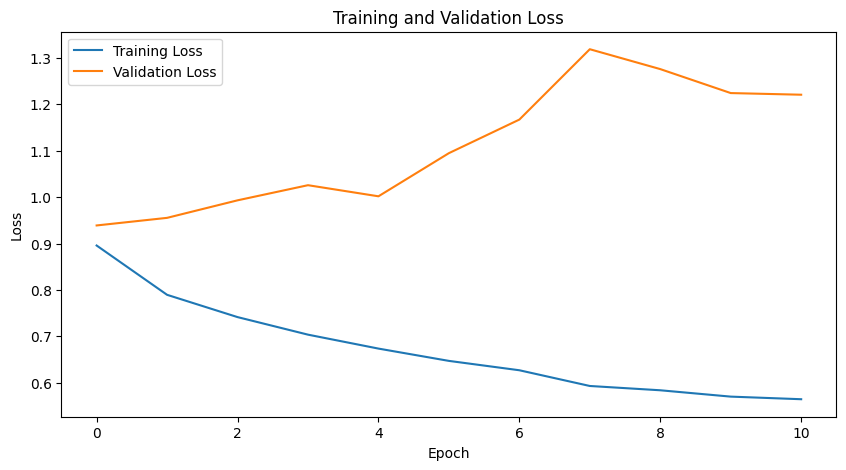

Test Loss: 1.0955
MAPE for PM: 13.65%
MAPE for PM_steam: 19.59%


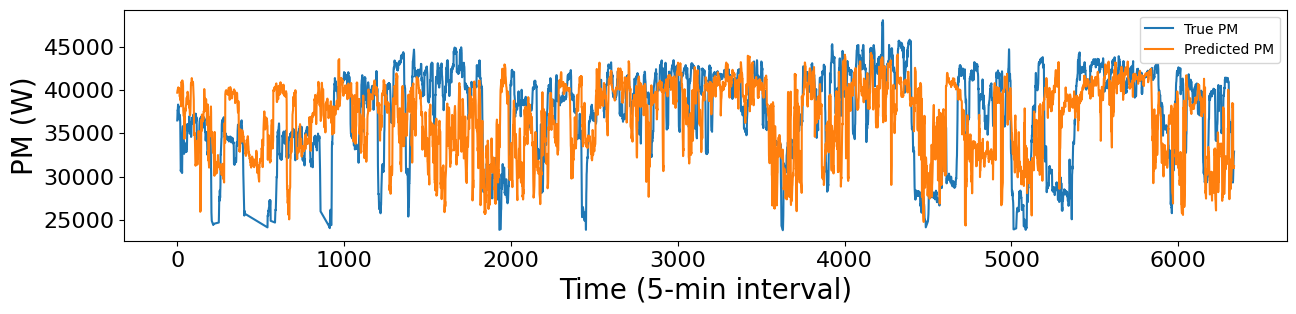

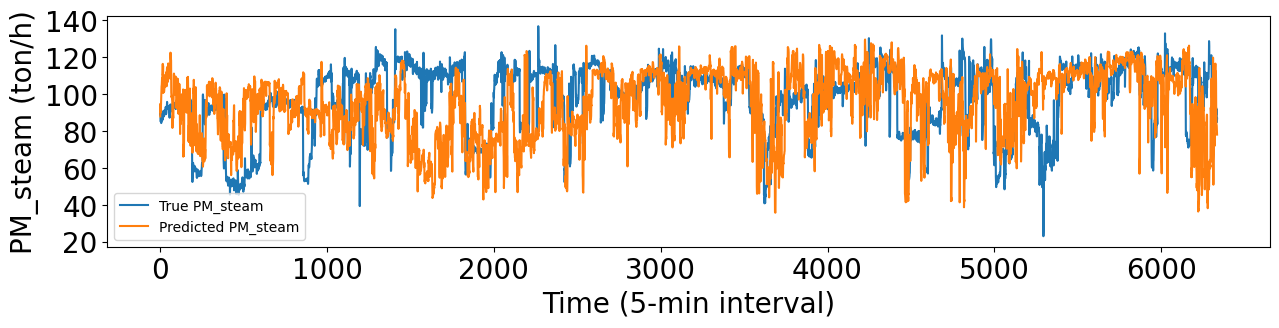

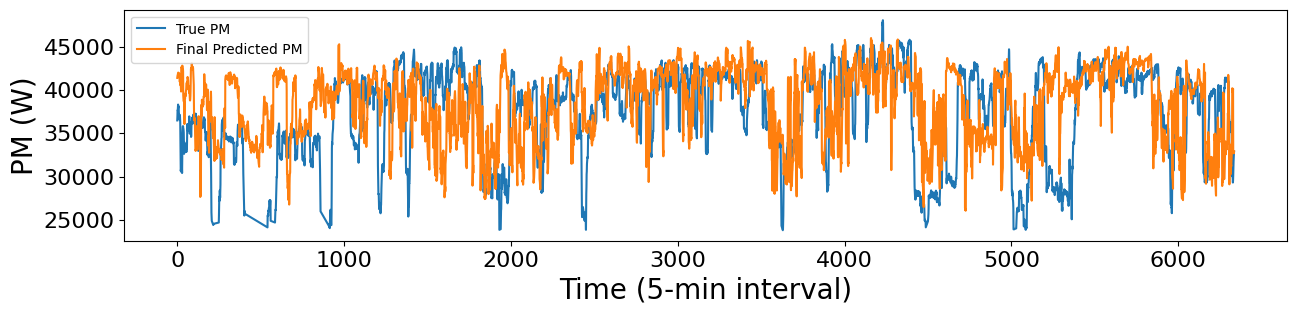

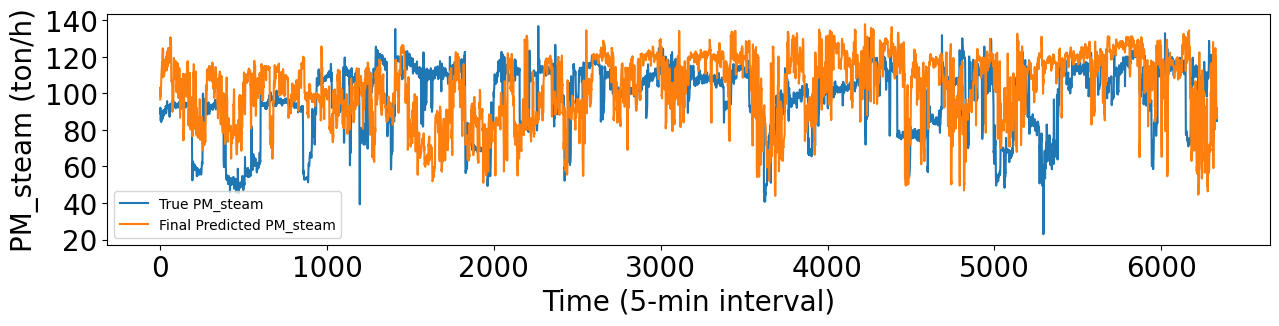

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.arima.model import ARIMA
import optuna

# Set seed for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and sort data
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data['Time'] = pd.to_datetime(data['Time'])
data = data.sort_values(by='Time')

# Define features
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Scale data
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)

# Define dataset sizes
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Convert to tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define upgraded model with more layers and heads
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=6, decoder_layers=6, d_model=128, nhead=16, dropout=0.3):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Initialize model
model = MultiDeT()

# Define loss function and optimizer with weight decay
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# Train model with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            output1 = output1.view(-1)
            output2 = output2.view(-1)

            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                output1 = output1.view(-1)
                output2 = output2.view(-1)

                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)
            break

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            output1 = output1.view(-1)
            output2 = output2.view(-1)

            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Evaluate the model
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Plot predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()

# Calculate residuals
residuals_pm = true_values_pm - predicted_values_pm
residuals_pm_steam = true_values_pm_steam - predicted_values_pm_steam

# Fit ARIMA model to residuals
arima_order = (5, 1, 0)  # Example order, you may need to tune this
arima_model_pm = ARIMA(residuals_pm, order=arima_order).fit()
arima_model_pm_steam = ARIMA(residuals_pm_steam, order=arima_order).fit()

# Forecast residuals using ARIMA
arima_forecast_pm = arima_model_pm.forecast(steps=len(residuals_pm))
arima_forecast_pm_steam = arima_model_pm_steam.forecast(steps=len(residuals_pm_steam))

# Combine predictions
final_predictions_pm = predicted_values_pm + arima_forecast_pm
final_predictions_pm_steam = predicted_values_pm_steam + arima_forecast_pm_steam

# Plot final predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(final_predictions_pm, label='Final Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot final predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(final_predictions_pm_steam, label='Final Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()

In [5]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import random
from statsmodels.tsa.arima.model import ARIMA
import optuna

# Set seed for reproducibility
random.seed(100)
np.random.seed(100)
torch.manual_seed(100)
torch.cuda.manual_seed(100)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Load and sort data
data = pd.read_csv('/Users/nguyendinhhuy/Desktop/Rolling/fortraining.csv')
data['Time'] = pd.to_datetime(data['Time'])
data = data.sort_values(by='Time')

# Define features
encoder_features = ['PM_lw1','PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7','PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7',
                    'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute']
pm_features = ['PM_lw1', 'PM_lw2', 'PM_lw3', 'PM_lw4', 'PM_lw5', 'PM_lw6', 'PM_lw7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_s1']
pm_steam_features = ['PM_s1', 'PM_s2', 'PM_s3', 'PM_s4', 'PM_s5', 'PM_s6', 'PM_s7', 'Weekday', 'Timesteps', 'PaperCategory_y', 'qty', 'PM_f', 'day', 'month', 'hour', 'minute','PM_lw1']
y = data[['PM', 'PM_steam']].values

# Scale data
scaler_encoder = StandardScaler()
scaler_pm = StandardScaler()
scaler_pm_steam = StandardScaler()
scaler_y = StandardScaler()

X_encoder = scaler_encoder.fit_transform(data[encoder_features])
X_pm = scaler_pm.fit_transform(data[pm_features])
X_pm_steam = scaler_pm_steam.fit_transform(data[pm_steam_features])
y = scaler_y.fit_transform(y)

# Define dataset sizes
total_samples = len(data)
train_percentage = 0.8
val_percentage = 0.1
test_percentage = 0.1

train_size = int(total_samples * train_percentage)
val_size = int(total_samples * val_percentage)
test_size = total_samples - train_size - val_size

train_size -= train_size % 288
val_size -= val_size % 288
test_size -= test_size % 288

# Convert to tensor
X_encoder = torch.tensor(X_encoder, dtype=torch.float32)
X_pm = torch.tensor(X_pm, dtype=torch.float32)
X_pm_steam = torch.tensor(X_pm_steam, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

# Create TensorDataset
train_dataset = TensorDataset(X_encoder[:train_size], X_pm[:train_size], X_pm_steam[:train_size], y[:train_size])
val_dataset = TensorDataset(X_encoder[train_size:train_size + val_size], X_pm[train_size:train_size + val_size], X_pm_steam[train_size:train_size + val_size], y[train_size:train_size + val_size])
test_dataset = TensorDataset(X_encoder[-test_size:], X_pm[-test_size:], X_pm_steam[-test_size:], y[-test_size:])

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Define upgraded model with more layers and heads
class Encoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dropout=0.1):
        super(Encoder, self).__init__()
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        x = self.encoder(x)
        return self.norm(x)

class Decoder(nn.Module):
    def __init__(self, num_layers, d_model, nhead, dropout=0.2):
        super(Decoder, self).__init__()
        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.norm = nn.LayerNorm(d_model)
        self.output_layer = nn.Linear(d_model, 1)

    def forward(self, memory, x):
        x = self.decoder(x, memory)
        x = self.norm(x)
        x = self.output_layer(x)
        return x

class MultiDeT(nn.Module):
    def __init__(self, encoder_layers=6, decoder_layers=6, d_model=128, nhead=16, dropout=0.3):
        super(MultiDeT, self).__init__()
        self.encoder = Encoder(encoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder1 = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)
        self.decoder2 = Decoder(decoder_layers, d_model=d_model, nhead=nhead, dropout=dropout)

        self.encoderLinear = nn.Sequential(
            nn.Linear(len(encoder_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder1_Linear = nn.Sequential(
            nn.Linear(len(pm_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )
        self.decoder2_Linear = nn.Sequential(
            nn.Linear(len(pm_steam_features), d_model),
            nn.BatchNorm1d(d_model),
            nn.ReLU(),
            nn.Dropout(dropout)
        )

    def forward(self, src, src_dec1, src_dec2):
        encoder_output = self.encoder(self.encoderLinear(src))

        decoder1_output = self.decoder1(encoder_output, self.decoder1_Linear(src_dec1))
        decoder2_output = self.decoder2(encoder_output, self.decoder2_Linear(src_dec2))

        return decoder1_output, decoder2_output

# Initialize model
model = MultiDeT()

# Define loss function and optimizer with weight decay
criterion = nn.MSELoss()
optimizer = optim.AdamW(model.parameters(), lr=0.0001, weight_decay=1e-3)

# Learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.2, patience=5, verbose=True)

# Train model with early stopping
def train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for X_enc, X_pm, X_pm_steam, y in train_loader:
            optimizer.zero_grad()
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            output1 = output1.view(-1)
            output2 = output2.view(-1)

            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])

            loss = 0.8 * loss1 + 0.2 * loss2
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * X_enc.size(0)

        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}')

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_enc, X_pm, X_pm_steam, y in val_loader:
                output1, output2 = model(X_enc, X_pm, X_pm_steam)

                output1 = output1.view(-1)
                output2 = output2.view(-1)

                loss1 = criterion(output1, y[:, 0])
                loss2 = criterion(output2, y[:, 1])

                loss = 0.8 * loss1 + 0.2 * loss2
                val_loss += loss.item() * X_enc.size(0)

        val_loss = val_loss / len(val_loader.dataset)
        val_losses.append(val_loss)
        print(f'Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}')

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_wts = model.state_dict()
        else:
            patience_counter += 1

        if patience_counter >= patience:
            print("Early stopping triggered")
            model.load_state_dict(best_model_wts)
            break

    return train_losses, val_losses

# Train the model
train_losses, val_losses = train_model_with_early_stopping(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs=100, patience=10)

# Plot training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Evaluate model
def evaluate_model(model, test_loader, criterion, scaler_y):
    model.eval()
    test_loss = 0.0
    true_values_pm = []
    true_values_pm_steam = []
    predicted_values_pm = []
    predicted_values_pm_steam = []

    with torch.no_grad():
        for X_enc, X_pm, X_pm_steam, y in test_loader:
            output1, output2 = model(X_enc, X_pm, X_pm_steam)

            output1 = output1.view(-1)
            output2 = output2.view(-1)

            loss1 = criterion(output1, y[:, 0])
            loss2 = criterion(output2, y[:, 1])
            loss = 0.8 * loss1 + 0.2 * loss2
            test_loss += loss.item() * X_enc.size(0)

            true_values_pm.extend(y[:, 0].cpu().numpy())
            true_values_pm_steam.extend(y[:, 1].cpu().numpy())
            predicted_values_pm.extend(output1.cpu().numpy())
            predicted_values_pm_steam.extend(output2.cpu().numpy())

    test_loss = test_loss / len(test_loader.dataset)
    print(f'Test Loss: {test_loss:.4f}')

    true_values_pm = np.array(true_values_pm)
    true_values_pm_steam = np.array(true_values_pm_steam)
    predicted_values_pm = np.array(predicted_values_pm)
    predicted_values_pm_steam = np.array(predicted_values_pm_steam)

    true_values = scaler_y.inverse_transform(np.vstack((true_values_pm, true_values_pm_steam)).T)
    predicted_values = scaler_y.inverse_transform(np.vstack((predicted_values_pm, predicted_values_pm_steam)).T)

    true_values_pm = true_values[:, 0]
    true_values_pm_steam = true_values[:, 1]
    predicted_values_pm = predicted_values[:, 0]
    predicted_values_pm_steam = predicted_values[:, 1]

    mape_pm = np.mean(np.abs((true_values_pm - predicted_values_pm) / true_values_pm)) * 100
    mape_pm_steam = np.mean(np.abs((true_values_pm_steam - predicted_values_pm_steam) / true_values_pm_steam)) * 100

    print(f'MAPE for PM: {mape_pm:.2f}%')
    print(f'MAPE for PM_steam: {mape_pm_steam:.2f}%')

    return true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam

# Evaluate the model
true_values_pm, true_values_pm_steam, predicted_values_pm, predicted_values_pm_steam, mape_pm, mape_pm_steam = evaluate_model(model, test_loader, criterion, scaler_y)

# Plot predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(predicted_values_pm, label='Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(predicted_values_pm_steam, label='Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()

# Calculate residuals
residuals_pm = true_values_pm - predicted_values_pm
residuals_pm_steam = true_values_pm_steam - predicted_values_pm_steam

# Fit ARIMA model to residuals
arima_order = (5, 1, 0)  # Example order, you may need to tune this
arima_model_pm = ARIMA(residuals_pm, order=arima_order).fit()
arima_model_pm_steam = ARIMA(residuals_pm_steam, order=arima_order).fit()

# Forecast residuals using ARIMA
arima_forecast_pm = arima_model_pm.forecast(steps=len(residuals_pm))
arima_forecast_pm_steam = arima_model_pm_steam.forecast(steps=len(residuals_pm_steam))

# Combine predictions
final_predictions_pm = predicted_values_pm + arima_forecast_pm
final_predictions_pm_steam = predicted_values_pm_steam + arima_forecast_pm_steam

# Plot final predictions vs. true values for PM
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm, label='True PM')
plt.plot(final_predictions_pm, label='Final Predicted PM')
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM (W)', fontsize=20)
plt.legend()
plt.show()

# Plot final predictions vs. true values for PM_steam
plt.figure(figsize=(15, 3))
plt.plot(true_values_pm_steam, label='True PM_steam')
plt.plot(final_predictions_pm_steam, label='Final Predicted PM_steam')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Time (5-min interval)', fontsize=20)
plt.ylabel('PM_steam (ton/h)', fontsize=20)
plt.legend()
plt.show()

/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/nn/modules/transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/Users/nguyendinhhuy/Library/Python/3.9/lib/python/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1/100, Training Loss: 0.8957
Epoch 1/100, Validation Loss: 0.9390
Epoch 2/100, Training Loss: 0.7895
Epoch 2/100, Validation Loss: 0.9553
Epoch 3/100, Training Loss: 0.7415
Epoch 3/100, Validation Loss: 0.9931
